In [19]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

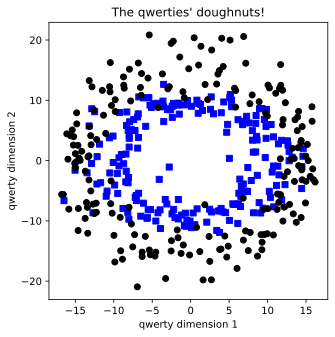

In [20]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Separate the data into DataLoaders

In [28]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_batchsize = 16
test_batchsize  = test_data.tensors[0].shape[0]
train_loader = DataLoader(train_data,batch_size=train_batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_batchsize)

In [29]:
# check sizes of data batches
for X,y in test_loader:
  print(X.shape,y.shape)

torch.Size([40, 2]) torch.Size([40, 1])


# Model stuff

In [30]:
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.hidden(x) )
    x = self.output(x)
    return x

In [31]:
# a function that creates the ANN model

def createANewModel():

  # grab an instance of the model class
  ANNQC = theModelClass()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.01)

  return ANNQC,lossfun,optimizer

In [32]:
# train the model

# global parameter
numepochs = 500

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy (NOTE: testing in batches!)
    tstacc = []
    for X,y in test_loader:
      yHat = ANNQC(X)
      tstacc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # now get the average accuracy over test-batches
    testAcc.append(np.mean(tstacc))

  # function output
  return trainAcc,testAcc


# Application

In [33]:
# create a model
ANNQC,lossfun,optimizer = createANewModel()

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

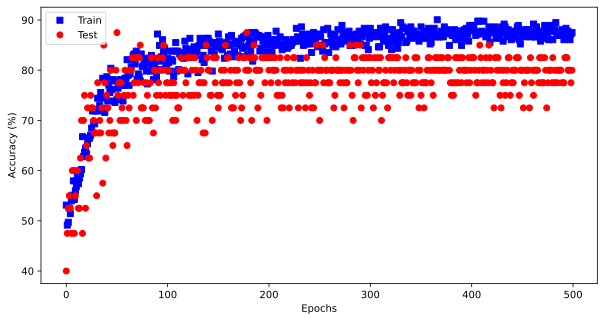

In [34]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()